In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.filterwarnings("ignore")
import json

from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re

import requests

In [2]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

В этом блокноте будут лежать эксперименты с моделями и данными. Для начала, посмотрим, сможем ли улучшить качество, сгенерировав больше фичей.

In [3]:
data_rare = pd.read_csv('data_rare.csv', index_col=[0])

In [4]:
data_rare.loc[~data_rare['handshake'].isna(), 'is_handshake'] = 1
data_rare.loc[data_rare['is_handshake'].isna(), 'is_handshake'] = 0

In [5]:
fingerprint = []
alert_message = []
certificate = []
is_selfsigned = []

for i in range(0, len(data_rare)):
    fingerprint.append(len(re.findall('fingerprint', data_rare['handshake'].fillna('0')[i], flags=0)))
    alert_message.append(len(re.findall('alert_message', data_rare['packets'].fillna('0')[i], flags=0)))
    certificate.append(len(re.findall('certificate', data_rare['handshake'].fillna('0')[i], flags=0)))
    is_selfsigned.append(len(re.findall("'is_selfsigned': True", data_rare['handshake'].fillna('0')[i], flags=0)))

data_rare['fingerprint'] = fingerprint
data_rare['alert_message'] = alert_message
data_rare['certificate'] = certificate
data_rare['is_selfsigned'] = is_selfsigned

In [6]:
df = data_rare.drop(['index', 'packets', 'handshake', 'timestamps'], axis = 1)
df['country'] = pd.read_csv('data.csv')['country']

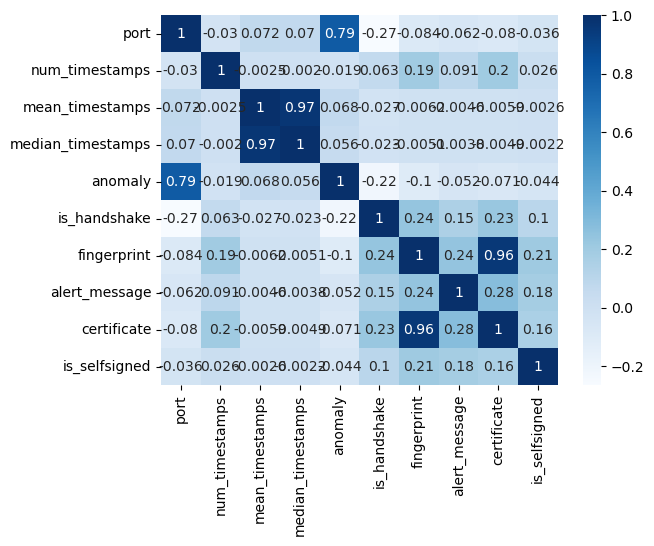

In [7]:
sns.heatmap(df[['addr', 'port', 'proto',
               'num_timestamps', 'mean_timestamps', 'median_timestamps', 'anomaly',
               'is_handshake', 'fingerprint', 'alert_message', 'certificate', 'is_selfsigned']].drop_duplicates().corr(), 
            cmap="Blues", annot=True);

# Подготовим данные:

1. Удалим скоррелированные колонки
2. Сделаем oversample для трейна
3. Скалируем

In [8]:
df = df.drop(['mean_timestamps', 'certificate', 'fingerprint'], axis = 1).drop_duplicates()

In [9]:
X = df[['addr', 'proto', 'num_timestamps', 
    'median_timestamps', 'anomaly', 'country', 'is_handshake',
       'alert_message', 'is_selfsigned']].drop_duplicates()
X = X.fillna(0)

X = X[X['addr'] != '10.4.19.138']

In [10]:
X.anomaly.nunique()

2

In [11]:
X.shape

(17459, 9)

In [12]:
X['addr_1'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_1']

X['addr_2'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_2']

In [13]:
X.anomaly.nunique()

2

In [14]:
X.shape

(17459, 11)

In [15]:
X_new = X.drop(['proto', 'country', 'addr_1', 'addr_2'], 
                     axis=1).merge(pd.get_dummies(X[['proto', 'country', 'addr_1', 'addr_2']], drop_first = True),
                                                    left_index = True, right_index=True)

In [16]:
X_new.anomaly.nunique()

2

In [17]:
y = X_new['anomaly']
X = X_new.drop(['anomaly', 'addr'], axis = 1)

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [19]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(Xtrain, ytrain)

In [100]:
y_over.value_counts()

0    11905
1    11905
Name: anomaly, dtype: int64

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_over)

In [21]:
X_over = scaler.transform(X_over)

In [22]:
Xtest = scaler.transform(Xtest)

In [23]:
from sklearn.metrics import make_scorer, fbeta_score

score = make_scorer(fbeta_score, beta=1.5)

In [24]:
# для проверки
def fbeta(beta, y, preds):
    d = pd.DataFrame(y, columns = ['y'])
    d['pr'] = preds
    TP = len(d[(d['y'] == 1) & (d['pr'] == 1)])
    TP_FP = len(d[(d['y'] == 1) & (d['pr'] == 1)]) + len(d[(d['y'] == 0) & (d['pr'] == 1)])
    TP_FN = len(d[(d['y'] == 1) & (d['pr'] == 1)]) + len(d[(d['y'] == 0) & (d['pr'] == 1)])
    precision = TP / TP_FP
    recall = TP / TP_FN
    return ((1 + beta*beta) * precision * recall) / (beta*beta*precision + recall)

В первую очередь возьмем катбуст из ноутбука с EDA и переберем параметры для улучшения качества.

# Итерация 1

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

params = {'depth': [None, 1, 5, 10],
          'learning_rate' : [None, 0.05, 0.1, 0.5],
          'iterations'    : [None, 100, 200]
         }

ctb = CatBoostClassifier(random_state=42, verbose=False)

ctb_model = GridSearchCV(ctb, params, scoring=score, return_train_score=True, verbose=2.1)
ctb_model.fit(X_over, y_over)
print(ctb_model.best_params_)
print(ctb_model.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.993, test=0.991) total time=  17.2s
[CV 2/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.993, test=0.993) total time=  16.4s
[CV 3/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.994, test=0.993) total time=  16.6s
[CV 4/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.994, test=0.991) total time=  16.6s
[CV 5/5] END depth=None, iterations=None, learning_rate=None;, score=(train=0.993, test=0.993) total time=  16.6s
[CV 1/5] END depth=None, iterations=None, learning_rate=0.05;, score=(train=0.994, test=0.992) total time=  18.2s
[CV 2/5] END depth=None, iterations=None, learning_rate=0.05;, score=(train=0.994, test=0.994) total time=  19.1s
[CV 3/5] END depth=None, iterations=None, learning_rate=0.05;, score=(train=0.994, test=0.993) total time=  17.5s
[CV 4/5] END depth=None, i

[CV 4/5] END depth=1, iterations=None, learning_rate=0.1;, score=(train=0.989, test=0.987) total time=  12.0s
[CV 5/5] END depth=1, iterations=None, learning_rate=0.1;, score=(train=0.989, test=0.987) total time=  12.0s
[CV 1/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.994, test=0.993) total time=  11.9s
[CV 2/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.994, test=0.994) total time=  11.9s
[CV 3/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.994, test=0.993) total time=  12.3s
[CV 4/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.994, test=0.992) total time=  11.8s
[CV 5/5] END depth=1, iterations=None, learning_rate=0.5;, score=(train=0.994, test=0.994) total time=  11.8s
[CV 1/5] END depth=1, iterations=100, learning_rate=None;, score=(train=0.979, test=0.979) total time=   4.5s
[CV 2/5] END depth=1, iterations=100, learning_rate=None;, score=(train=0.981, test=0.978) total time=   4.5s
[CV 3/5] E

[CV 4/5] END depth=5, iterations=100, learning_rate=0.05;, score=(train=0.968, test=0.963) total time=   4.3s
[CV 5/5] END depth=5, iterations=100, learning_rate=0.05;, score=(train=0.966, test=0.965) total time=   4.9s
[CV 1/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.981, test=0.981) total time=   4.5s
[CV 2/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.980, test=0.977) total time=   4.6s
[CV 3/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.981, test=0.980) total time=   4.9s
[CV 4/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.981, test=0.980) total time=   4.5s
[CV 5/5] END depth=5, iterations=100, learning_rate=0.1;, score=(train=0.981, test=0.981) total time=   4.5s
[CV 1/5] END depth=5, iterations=100, learning_rate=0.5;, score=(train=0.994, test=0.992) total time=   4.7s
[CV 2/5] END depth=5, iterations=100, learning_rate=0.5;, score=(train=0.994, test=0.993) total time=   4.9s
[CV 3/5] END dept

[CV 4/5] END depth=10, iterations=200, learning_rate=None;, score=(train=0.994, test=0.992) total time=  12.9s
[CV 5/5] END depth=10, iterations=200, learning_rate=None;, score=(train=0.994, test=0.994) total time=  15.2s
[CV 1/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.988, test=0.986) total time=  13.1s
[CV 2/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.988, test=0.985) total time=  13.0s
[CV 3/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.988, test=0.986) total time=  12.9s
[CV 4/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.988, test=0.986) total time=  12.3s
[CV 5/5] END depth=10, iterations=200, learning_rate=0.05;, score=(train=0.988, test=0.987) total time=  12.4s
[CV 1/5] END depth=10, iterations=200, learning_rate=0.1;, score=(train=0.993, test=0.991) total time=  12.4s
[CV 2/5] END depth=10, iterations=200, learning_rate=0.1;, score=(train=0.993, test=0.992) total time=  12.8s
[CV

KeyError: 'iterations'

In [26]:
print(ctb_model.best_params_)
print(ctb_model.best_score_)

{'depth': 5, 'iterations': None, 'learning_rate': 0.5}
0.9943214436559412


In [27]:
clf = CatBoostClassifier(random_state=42, verbose=False,
                        depth= 5, iterations= None, learning_rate= 0.5)

In [28]:
model_ctb = clf.fit(X_over, y_over)

In [29]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

print (f"roc_auc_score на трейне: {round(roc_auc_score(y_over, model_ctb.predict(X_over)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_ctb.predict(Xtest)), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.97


In [30]:
print (f"f1_score на трейне: {round(fbeta_score(y_over, model_ctb.predict(X_over), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_ctb.predict(Xtest), beta=1.5), 2)}")

f1_score на трейне: 1.0
f1_score на тесте: 0.8


In [31]:
fbeta(1.5, list(y_over), list(model_ctb.predict(X_over)))

0.9863297431648715

In [32]:
fbeta(1.5, list(ytest), list(model_ctb.predict(Xtest)))

0.591304347826087

In [33]:
# сильно переобучилась под трейн

model AUC score: 0.9696503194994142


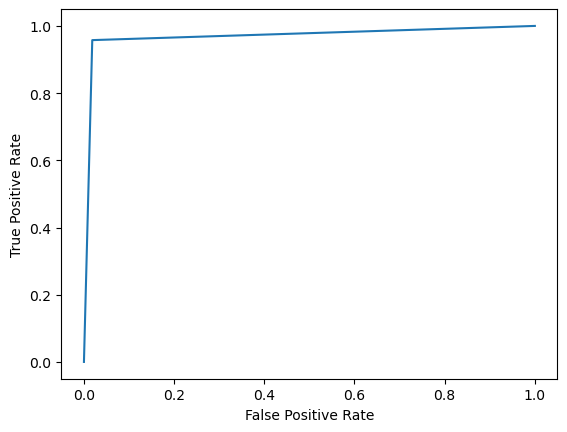

In [34]:
plot_roc_curve(ytest, model_ctb.predict(Xtest))
print(f'model AUC score: {roc_auc_score(ytest, model_ctb.predict(Xtest))}')

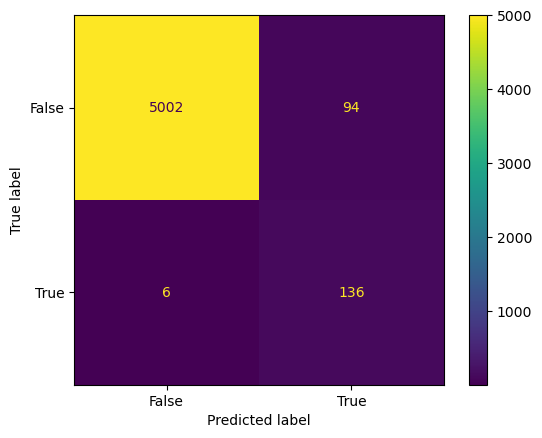

In [35]:
confusion_matrix = confusion_matrix(ytest, model_ctb.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()
# много ошибается на определении аноималии

In [36]:
feat = pd.DataFrame(model_ctb.feature_importances_,
            columns=['coefs'])
feat['features'] = list(X_new.drop(['addr', 'anomaly'], axis=1).columns)

In [37]:
feat = feat.sort_values('coefs', ascending=False).head(20)

<function matplotlib.pyplot.show(close=None, block=None)>

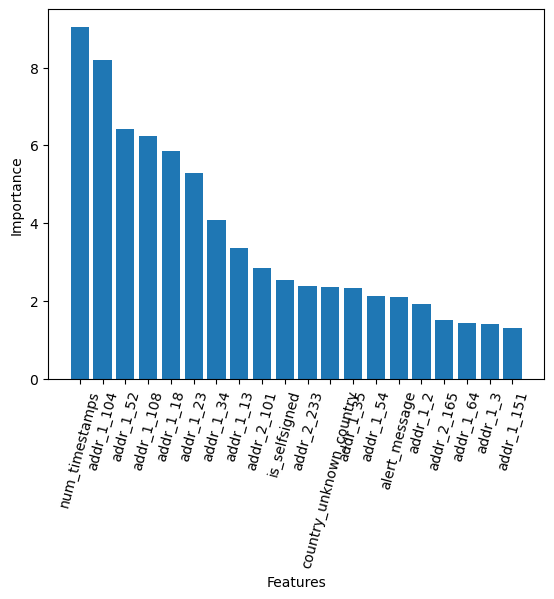

In [38]:
plt.bar(feat['features'], feat['coefs'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=75)
plt.show

In [21]:
import pickle
pickle.dump(model, open('ctb_model.pkl', 'wb'))

In [22]:
import joblib

joblib.dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

# Итерация 2

max_depth поставить меньше

In [39]:
from sklearn.ensemble import RandomForestClassifier

params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 4, 5],
    'criterion' :['gini', 'entropy']
    }
rfc = RandomForestClassifier(random_state=42)

rfc_model = GridSearchCV(rfc, params, scoring=score)
rfc_model.fit(X_over, y_over)
print(rfc_model.best_params_)
print(rfc_model.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500}
0.9525755394322329


In [43]:
clf = RandomForestClassifier(random_state=42, criterion = 'entropy',
                            max_depth= 4, max_features = 'log2', n_estimators = 500)

In [44]:
model_rfc = clf.fit(X_over, y_over)

In [45]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_over, model_rfc.predict(X_over)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_rfc.predict(Xtest)), 2)}")

roc_auc_score на трейне: 0.92
roc_auc_score на тесте: 0.92


In [46]:
print (f"f1_score на трейне: {round(fbeta_score(y_over, model_rfc.predict(X_over), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_rfc.predict(Xtest), beta=1.5), 2)}")

f1_score на трейне: 0.95
f1_score на тесте: 0.35


In [47]:
fbeta(1.5, list(y_over), list(model_rfc.predict(X_over)))

0.8616197437938771

In [48]:
fbeta(1.5, list(ytest), list(model_rfc.predict(Xtest)))

0.14300100704934543

In [49]:
# сильно переобучилась

# Итерация 3

In [50]:
from sklearn.linear_model import LogisticRegression

params = {"penalty":["none","l2","l1"]}

lr = LogisticRegression(random_state=42)

lr_model = GridSearchCV(lr, params, scoring=score)
lr_model.fit(X_over, y_over)
print(lr_model.best_params_)
print(lr_model.best_score_)

{'penalty': 'l2'}
0.9939635265595552


In [51]:
clf = LogisticRegression(random_state=42, penalty= 'l2')
model_lr = clf.fit(X_over, y_over)

In [52]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_over, model_lr.predict(X_over)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_lr.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_over, model_lr.predict(X_over), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_lr.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.99
f1_score на трейне: 0.99
f1_score на тесте: 0.82


In [53]:
# здесь куда лучше результат

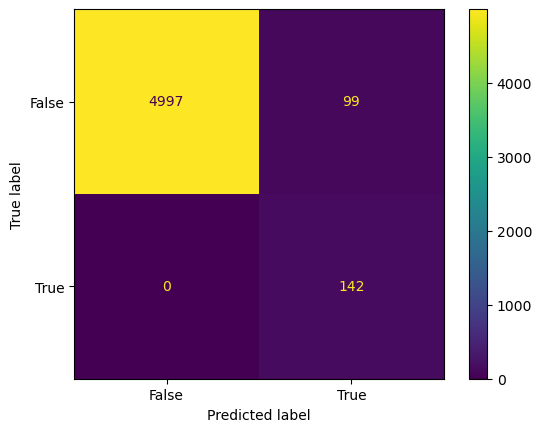

In [54]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


confusion_matrix = confusion_matrix(ytest, model_lr.predict(Xtest))

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

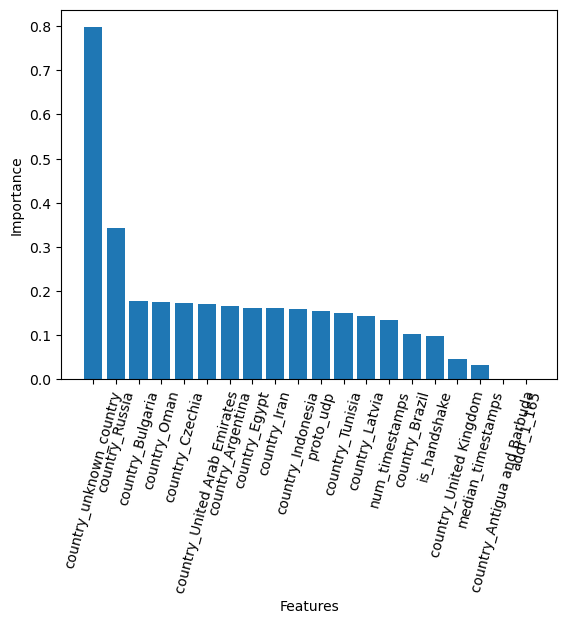

In [55]:
feat = pd.DataFrame(model_lr.coef_[0],
            columns=['coefs'])
feat['features'] = list(X_new.drop(['addr', 'anomaly'], axis=1).columns)
feat = feat.sort_values('coefs', ascending=False).head(20)

plt.bar(feat['features'], feat['coefs'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=75)
plt.show

In [56]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = model_lr.predict(Xtest)

In [57]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# 3 процента выбросов не задетектировали

0.0

In [58]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и два процента нормальных соединений

0.01942700156985871

In [59]:
len(C[(C['real']==1)])

142

# Итерация 4: несколько моделей из pyod

In [61]:
from pyod.models.inne import INNE

params = {'n_estimators': [50,100,200,500]}

inn = INNE(random_state=42)

inn_model = GridSearchCV(inn, params, scoring=score)
inn_model.fit(X_over, y_over)
print(inn_model.best_params_)
print(inn_model.best_score_)

{'n_estimators': 200}
0.013081953617742836


In [63]:
clf = INNE(random_state=42, n_estimators = 200)
model_inn = clf.fit(X_over, y_over)

In [64]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_over, model_inn.predict(X_over)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_inn.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_over, model_inn.predict(X_over), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_inn.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.41
roc_auc_score на тесте: 0.42
f1_score на трейне: 0.02
f1_score на тесте: 0.01


In [73]:
# здесь совсем слабо
# Возможно, нормальная модель, но надо наоборот развернуть значения

In [65]:
pr = list(model_inn.predict(Xtest))
pr[pr.index(1)] = 3
pr[pr.index(0)] = 1
pr[pr.index(3)] = 0

fbeta_score(ytest, pr, beta=1.5)
# кажется, развернуть значения не сработало

0.009935040122277418

In [66]:
from pyod.models.cblof import CBLOF

params = {'n_clusters': [5,10,50,100]
         }

cblof = CBLOF(random_state=42)

cblof_model = GridSearchCV(cblof, params, scoring=score)
cblof_model.fit(X_over, y_over)
print(cblof_model.best_params_)
print(cblof_model.best_score_)

{'n_clusters': 5}
0.0


In [94]:
clf = CBLOF(random_state=42, n_clusters = 5)
model_cblof = clf.fit(X_over, y_over)

In [95]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_over, model_cblof.predict(X_over)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_cblof.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_over, model_cblof.predict(X_over), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_cblof.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.4
roc_auc_score на тесте: 0.41
f1_score на трейне: 0.0
f1_score на тесте: 0.01


In [96]:
pr = list(model_cblof.predict(Xtest))

In [97]:
pr[pr.index(1)] = 3
pr[pr.index(0)] = 1
pr[pr.index(3)] = 0

In [90]:
fbeta_score(ytest, pr, beta=1.5)
# кажется, развернуть значения не сработало

0.0014485424577222743

In [67]:
from pyod.models.dif import DIF

params = {'batch_size': [8,256,1000]
         }
dif = DIF(random_state=42)

dif_model = GridSearchCV(dif, params, scoring=score)
dif_model.fit(X_over, y_over)
print(dif_model.best_params_)
print(dif_model.best_score_)

{'batch_size': 8}
0.03592316474712513


In [68]:
clf = DIF(random_state=42, batch_size = 8)
model_dif = clf.fit(X_over, y_over)

In [69]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_over, model_dif.predict(X_over)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_dif.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_over, model_dif.predict(X_over), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_dif.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.5
roc_auc_score на тесте: 0.5
f1_score на трейне: 0.0
f1_score на тесте: 0.0


In [70]:
from pyod.models.ocsvm import OCSVM

params = {'kernel': ['poly', 'rbf', 'sigmoid']
         }
ocsvm = OCSVM()

ocsvm_model = GridSearchCV(ocsvm, params, scoring=score)
ocsvm_model.fit(X_over, y_over)
print(ocsvm_model.best_params_)
print(ocsvm_model.best_score_)

{'kernel': 'poly'}
0.25361146107970267


In [73]:
clf = OCSVM(kernel= 'poly')
model_ocsvm = clf.fit(X_over, y_over)

In [74]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_over, model_ocsvm.predict(X_over)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_ocsvm.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_over, model_ocsvm.predict(X_over), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_ocsvm.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.59
roc_auc_score на тесте: 0.56
f1_score на трейне: 0.25
f1_score на тесте: 0.17


In [76]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'max_depth': [3, 10, 50],
          'learning_rate' : [0.01,0.1,0.5],
          'n_estimators': [20, 100, 200]
         }
gbc = GradientBoostingClassifier(random_state=42)

gbc_model = GridSearchCV(gbc, params, scoring=score, verbose=2.1)
gbc_model.fit(X_over, y_over)
print(gbc_model.best_params_)
print(gbc_model.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.821 total time=   8.4s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.824 total time=   7.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.824 total time=   8.6s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.817 total time=   8.2s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.823 total time=   8.8s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.864 total time=  45.3s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.877 total time=  48.4s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.876 total time=  47.9s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.860 total time=  42.6s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.874 to

[CV 1/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.994 total time=13.0min
[CV 2/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.994 total time=12.9min
[CV 3/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.994 total time=13.7min
[CV 4/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.992 total time=12.7min
[CV 5/5] END learning_rate=0.1, max_depth=50, n_estimators=200;, score=0.994 total time=13.1min
[CV 1/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.954 total time=   6.0s
[CV 2/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.952 total time=   6.0s
[CV 3/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.955 total time=   6.1s
[CV 4/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.951 total time=   6.1s
[CV 5/5] END learning_rate=0.5, max_depth=3, n_estimators=20;, score=0.954 total time=   6.1s
[CV 1/5] END learning_rate=0.5, max_depth=3, n_est

In [77]:
clf = GradientBoostingClassifier(random_state=42, max_depth = 10, 
                                learning_rate = 0.5, n_estimators = 200)
model_gbc = clf.fit(X_over, y_over)

In [78]:
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_over, model_gbc.predict(X_over)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, model_gbc.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_over, model_gbc.predict(X_over), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, model_gbc.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.95
f1_score на трейне: 1.0
f1_score на тесте: 0.77


In [79]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = model_gbc.predict(Xtest)

In [80]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# меньше одного процента выбросов

0.07746478873239436

In [81]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и два процента нормальных соединений

0.01942700156985871

Итого, лучше всего себя проявила логистическая регрессия, градиентный бустинг и катбуст. Попробуем чуть улучшить логистическую регессию и построить над ней бэггинг.

In [84]:
from sklearn.ensemble import BaggingClassifier

lr = LogisticRegression(random_state=42, penalty= 'l2')
bc = BaggingClassifier(lr)
bag = bc.fit(X_over, y_over)
print (f"roc_auc_score на трейне: {round(roc_auc_score(y_over, bag.predict(X_over)), 2)}")
print (f"roc_auc_score на тесте: {round(roc_auc_score(ytest, bag.predict(Xtest)), 2)}")
print (f"f1_score на трейне: {round(fbeta_score(y_over, bag.predict(X_over), beta=1.5), 2)}")
print (f"f1_score на тесте: {round(fbeta_score(ytest, bag.predict(Xtest), beta=1.5), 2)}")

roc_auc_score на трейне: 0.99
roc_auc_score на тесте: 0.99
f1_score на трейне: 0.99
f1_score на тесте: 0.82


In [85]:
C = pd.DataFrame(list(ytest), columns=['real'])
C['preds'] = bag.predict(Xtest)

In [86]:
len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)])
# меньше 1 процента процента выбросов не задетектировали

0.0

In [87]:
len(C[(C['real']==1) & (C['preds']==0)])

0

In [88]:
len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)])
# и два процента нормальных соединений

0.019819466248037678

Бэггинг ничего не улучшил

In [98]:
models_list = [model_ctb, model_rfc, model_lr, model_inn, model_cblof, model_dif, model_ocsvm, model_gbc, bag]
perc_anomaly = []
perc_usual = []

for i in models_list:
    C = pd.DataFrame(list(ytest), columns=['real'])
    C['preds'] = i.predict(Xtest)
    perc_anomaly.append(len(C[(C['real']==1) & (C['preds']==0)]) / len(C[(C['real']==1)]))
    perc_usual.append(len(C[(C['real']==0) & (C['preds']==1)]) / len(C[(C['real']==0)]))

In [99]:
models_names = ['model_ctb', 'model_rfc', 'model_lr', 'model_inn', 'model_cblof', 'model_dif', 'model_ocsvm', 'model_gbc', 'bag']
mistakes_df = pd.DataFrame(index = models_names, columns = ['perc_anomaly', 'perc_usual'])
mistakes_df['perc_anomaly'] = perc_anomaly
mistakes_df['perc_usual'] = perc_usual
mistakes_df

,perc_anomaly,perc_usual
model_ctb,0.042254,0.018446
model_rfc,0.000000,0.166994
model_lr,0.000000,0.019427
model_inn,0.971831,0.193289
model_cblof,0.971831,0.207418
model_dif,1.000000,0.000000
model_ocsvm,0.866197,0.003925
model_gbc,0.077465,0.019427
bag,0.000000,0.019819
